# Thermal time

In [1]:
import os
import copy
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5, 2]
from eocrops.inputs.meteoblue import WeatherDownload
from eocrops.climatools.format_data import WeatherPostprocess
from eocrops.climatools import resampling
from eocrops.tasks import curve_fitting
from eocrops.utils import base_functions as utils
from shapely.geometry import Point

/home/johann/anaconda3/envs/eo-crops/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the file

In [12]:
# Define the path to get store the data
PATH_EXPERIMENT = os.path.join("../data", "experiments")
# Dates of interest
TIME_INTERVAL = ("2017-08-15", "2018-07-15")

YEAR = TIME_INTERVAL[-1].split("-")[0]

if not os.path.exists(PATH_EXPERIMENT):
    os.mkdir(PATH_EXPERIMENT)

In [13]:
# Read the dataset
## Read the excel file
sentinel_data = pd.read_excel("../data/rapeseed_data_s1.xlsx")
sentinel_data = sentinel_data.sort_values(by=["ID", "band"])
## Define the features
features_data = [("DATA", f, f, "float32", 1) for f in sentinel_data["band"].unique()]

In [14]:
## Define the meta data
### Get the informations regarding the location
meta_data = sentinel_data[["ID", "lon", "lat"]].drop_duplicates()
### Add in the metadata file the dates of interest in the time series
meta_data["timestamp"] = [TIME_INTERVAL]
### Convert the coordinates into Point
meta_data["geometry"] = [
    Point(x, y) for x, y in zip(meta_data["lon"], meta_data["lat"])
]
feature_vector = [(col_name, "string") for col_name in meta_data.columns]
np.save(file=f"{PATH_EXPERIMENT}/meta_data.npy", arr=meta_data.values)

/home/johann/anaconda3/envs/eo-crops/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [45]:
## Define the 3D array from Sentinel-1 data
### Keep only band values
sentinel_bands = sentinel_data.drop(["ID", "lon", "lat", "band"], axis=1)
dates = sentinel_bands.columns
sentinel_values = sentinel_bands.values
### Reshape in 3D array
array_data = sentinel_values.reshape(
    sentinel_values.shape[0] // len(features_data),
    len(features_data),
    sentinel_values.shape[1],
)
array_data = np.moveaxis(array_data, 1, 2)

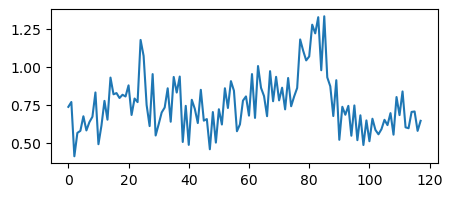

In [49]:
# Compute RVI=4*VH/(VV+VH)
RVI = 4 * array_data[..., 0] / (array_data[..., 0] + array_data[..., 1])
plt.plot(RVI.flatten())

/tmp/ipykernel_45200/3585828634.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.alltrue(sentinel_data.iloc[0, :].values == array_data[0, :, 0])


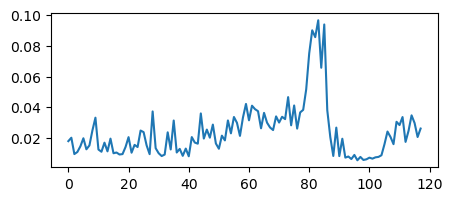

In [47]:
### Check if the reshape worked well
np.alltrue(sentinel_data.iloc[0, :].values == array_data[0, :, 0])
### Plot the first observation
plt.plot(array_data[0, :, 0])
plt.show()

In [48]:
## Get the day of the year of the samples
dates = [datetime.datetime.strptime(str(k), "%Y%m%d") for k in dates]
## Subset for the season of interest
### Usually for rapeseed, season start 15 August previous year
start_season = datetime.datetime.strptime(TIME_INTERVAL[0], "%Y-%m-%d")
### And harvest is up to mid-July
end_season = datetime.datetime.strptime(TIME_INTERVAL[1], "%Y-%m-%d")

subset_dates = [k for k in dates if k >= start_season and k <= end_season]
len(subset_dates)

55

## Check if we have a fixed number of days between acquisition dates

In [18]:
# Check the dates and resample the data over fixed periods
def days_since_first(dates):
    """Compute number of days since the start of the season"""
    first_date = dates[0]
    days_since = [(d - first_date).days for d in dates]
    return np.array(days_since)


def is_evenly_spaced(lst, step):
    """Check if day of the year are evenly spaced"""
    for i in range(1, len(lst)):
        if lst[i] - lst[i - 1] != step:
            print(lst[i])
            return False
    return True


# Day of the year since start of season (15th August)
subset_dates_doy = days_since_first(subset_dates)
array_data = array_data[:, : len(subset_dates_doy), :]
# Check if doy are evenly spaced, otherwise we need to resample
print(is_evenly_spaced(subset_dates_doy, subset_dates_doy[1] - subset_dates_doy[0]))

144
False


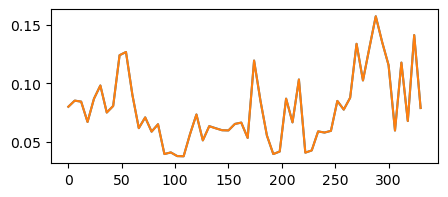

In [19]:
# Resample the data since we do not have regular dates
curve_fit = curve_fitting.CurveFitting(
    range_doy=(subset_dates_doy[0], subset_dates_doy[-1])
)

new_dates_doy, array_resample = curve_fit.resample_ts(
    doy=subset_dates_doy,
    ts_mean_=array_data,
    resampling=6,  # Resample every 6 days
)
# Check the results : any changes
plt.plot(subset_dates_doy, array_data[0, :, 1])
plt.plot(new_dates_doy, array_resample[0, :, 1])
plt.show()

(1, 56, 2)


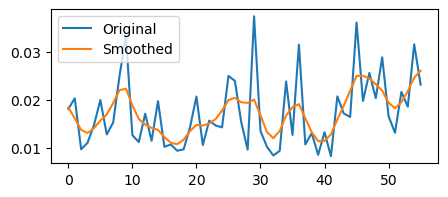

In [37]:
# Smooth the signal
print(array_resample.shape)

array_resample_vh = curve_fit.fit_whitakker(array_resample[0, :], degree_smoothing=2)

# Check the results : any changes
plt.plot(array_resample[0, :, 0])
plt.plot(array_resample_vh[:, 0])
plt.legend(["Original", "Smoothed"])
plt.show()

In [62]:
# Save the satellite data
np.save(file=f"{PATH_EXPERIMENT}/satellite_data.npy", arr=array_resample)

## Extract weather data

In [ ]:
# Extract the weather data
## Download the data using meteoblue API
import nest_asyncio

nest_asyncio.apply()

pipeline_cehub = WeatherDownload(
    api_key="",  # Please put your meteoblue API here
    shapefile=meta_data,
    id_column="ID",  # column from the meta_data with the ID of the field
    timestamp_column="timestamp",  # timestamp of interest
)

query_base = [
    {"domain": "ERA5T", "gapFillDomain": "ERA5", "timeResolution": "daily", "codes": []}
]

query_sum = copy.deepcopy(query_base)
query_sum[0]["codes"].extend(
    [
        {
            "code": 731,
            "level": "2 m above gnd",
            "aggregation": "sum",
            "gddBase": 0,  # Tmin for rapeseed
            "gddLimit": 30,  # Tmax for rapeseed
        }
    ]
)
weather_data = pipeline_cehub.execute(query=query_sum)
weather_data.to_csv(f"{PATH_EXPERIMENT}/GDD_data_raw.csv", index=False)

In [57]:
weather_data.head(2)

,location,lat,lon,asl,variable,unit,level,timeResolution,aggregation,timestamp,value,69019A3B-92C5-4EA8-AA93-A7F1098B4BD3
1,1,45.50000,-0.50000,51.251,Growing Degree days daily max/min,GDDc,2 m above gnd,daily,none,20170815T0000,20.619999,69019A3B-92C5-4EA8-AA93-A7F1098B4BD3
2,1,45.50000,-0.50000,51.251,Growing Degree days daily max/min,GDDc,2 m above gnd,daily,none,20170816T0000,20.814999,69019A3B-92C5-4EA8-AA93-A7F1098B4BD3


In [60]:
## Format the data to compute accumulated GDUs
weather_data = pd.read_csv(f"{PATH_EXPERIMENT}/GDD_data_raw.csv")

pipeline_refactor = WeatherPostprocess(
    shapefile=meta_data, id_column="ID", timestamp_column="timestamp"
)
daily_gdus = pipeline_refactor.execute(
    df_weather=weather_data, stat="sum", return_pivot=True
)
daily_gdus.to_csv(f"{PATH_EXPERIMENT}/GDD_data.csv", index=False)

/home/johann/anaconda3/envs/eo-crops/lib/python3.9/site-packages/eocrops/climatools/format_data.py:160: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[["period", "location"]]


## Thermal time resampling

In [63]:
# Thermal time resampling
gdu = resampling.TempResampling(
    range_dates=TIME_INTERVAL,  #  extracted from weather data
    stop=TIME_INTERVAL[
        -1
    ],  # Stopping date for yield prediction model (useful for in season)
    id_column="ID",  # Ids of the observations, which is the saving path of EOPatch
    smooth=True,  # Apply smoothing using sg filter
    period_nas_rate=0.2,
)

# You must load those 3 files that you did in the step data_loader to do the resampling (prepared before)
## Meta data
meta_data = gdu.load_meta_data(
    feature_vector=feature_vector, filepath=f"{PATH_EXPERIMENT}/meta_data.npy"
)
## Weather data
weather_data = gdu.load_weather_data(filepath=f"{PATH_EXPERIMENT}/GDD_data.csv")
## Satellite data
x_s1 = gdu.load_sat_data(filepath=f"{PATH_EXPERIMENT}/satellite_data.npy")

In [64]:
# Define the parameters for temporal resampling
kwargs_input = dict(
    stat="mean",  # aggregation over GDD periods (mean)
    thermal_time=True,  # resample over thermal time? otherwise, calendar time
    features_data=features_data,
    increment=120,  # Number of GDDs per period (if thermal_time=False, you can specify 10 for 10-day period)
    period_length=6,
)

# Prepare the output file with VH and VV resampled over thermal time
ds = pd.DataFrame()
for _, _, fname_, _, num in features_data:
    # Resample satellite data for a given fname (VV or VH)
    output, _ = gdu.resample_s2(**kwargs_input, fname=fname_)
    # Contenate all the bands
    ds = utils.concatenate_outputs(ds, output, fname_, id_column="ID")

VH
VV


/home/johann/anaconda3/envs/eo-crops/lib/python3.9/collections/__init__.py:431: RuntimeWarning: coroutine 'WeatherDownload._get_jobIDs_from_query' was never awaited
  __new__ = eval(code, namespace)
/home/johann/anaconda3/envs/eo-crops/lib/python3.9/site-packages/eocrops/utils/base_functions.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(output)


In [65]:
ds.head()

,ID,"(VH, 0)","(VH, 1)","(VH, 2)","(VH, 3)","(VH, 4)","(VH, 5)","(VH, 6)","(VH, 7)","(VH, 8)",...,"(VV, 26)","(VV, 27)","(VV, 28)","(VV, 29)","(VV, 30)","(VV, 31)","(VV, 32)","(VV, 33)","(VV, 34)","(VV, 35)"
0,1,0.020873,0.015591,0.012079,0.011867,0.015831,0.015476,0.01725,0.024987,0.023762,...,0.119587,0.127084,0.140267,0.127745,0.100579,0.094846,0.078625,0.046503,0.024062,0.023308


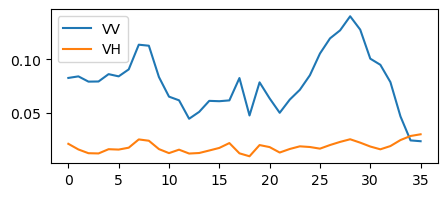

In [66]:
# Check the results after thermal resampling
cols_vv = [k for k in ds.columns if "VV" in k]
cols_vh = [k for k in ds.columns if "VH" in k]
plt.plot(ds[cols_vv].iloc[0, :].values)
plt.plot(ds[cols_vh].iloc[0, :].values)
plt.legend(["VV", "VH"])
plt.show()